<a href="https://colab.research.google.com/github/FalduPriyansh/123/blob/main/ML_Project_EnhancedFixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install dependencies (skip if already installed)
!pip install -q chembl_webresource_client rdkit scikit-learn imbalanced-learn pandas matplotlib seaborn


In [5]:
# Imports
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Step 1: Download dataset for acetylcholinesterase
print("Fetching bioactivity data from ChEMBL...")
target = new_client.target
activity = new_client.activity
target_query = target.search("acetylcholinesterase")
target_df = pd.DataFrame.from_dict(target_query)
selected_target = target_df.target_chembl_id[0]
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
data = pd.DataFrame.from_dict(res)
print(f"Fetched {len(data)} records.")


Fetching bioactivity data from ChEMBL...
Fetched 18 records.


In [7]:

# Step 2: Data cleaning and labeling
data = data[["molecule_chembl_id", "canonical_smiles", "standard_value"]].dropna()
data["standard_value"] = pd.to_numeric(data["standard_value"], errors="coerce")
data = data.dropna()
data = data[data["standard_value"] < 1000000]  # Filter outliers
data["bioactivity_class"] = data["standard_value"].apply(lambda x: 1 if x < 10000 else 0)


In [8]:
data.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL463210,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,1830.0,1
1,CHEMBL2252723,CCOP(=O)(OCC)SCCCCCCCCCCN1C(=O)c2ccccc2C1=O,112720.0,0
2,CHEMBL2252722,CCOP(=O)(OCC)SCCCCCCCCCN1C(=O)c2ccccc2C1=O,37500.0,0
3,CHEMBL2252721,CCOP(=O)(OCC)SCCCCCCCCN1C(=O)c2ccccc2C1=O,4500.0,1
4,CHEMBL2252851,CCOP(=O)(OCC)SCCCCCCCN1C(=O)c2ccccc2C1=O,1840.0,1


In [9]:
# Step 3: Convert SMILES to Morgan fingerprints
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

generator = GetMorganGenerator(radius=2, fpSize=1024)

def mol_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = generator.GetFingerprint(mol)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    return None


# Generate fingerprints and filter out invalid ones
features = []
labels = []
for i, row in data.iterrows():
    fp = mol_to_fp(row["canonical_smiles"])
    if fp is not None:
        features.append(fp)
        labels.append(row["bioactivity_class"])

X = np.array(features)
y = np.array(labels)



In [10]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# Check class distribution
counter = Counter(y)
minority_class = min(counter, key=counter.get)
minority_count = counter[minority_class]



from collections import Counter
from imblearn.over_sampling import SMOTE

# Count samples per class
class_counts = Counter(y)
minority_class = min(class_counts, key=class_counts.get)
minority_count = class_counts[minority_class]

# Only apply SMOTE if there's enough samples
if minority_count > 1:
    k_neighbors = min(5, minority_count - 1)
    sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_res, y_res = sm.fit_resample(X, y)
else:
    print("⚠️ Not enough minority samples for SMOTE. Using original data.")
    X_res, y_res = X, y


In [11]:
from collections import Counter
print(Counter(y))


Counter({np.int64(1): 12, np.int64(0): 5})


In [12]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)


In [13]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, k_neighbors=3)
X_res, y_res = sm.fit_resample(X, y)


In [14]:
# Step 5: Split data and train model
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Step 6: Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Model Accuracy: {round(accuracy * 100, 2)}%")
print(f"F1 Score: {round(f1, 2)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 80.0%
F1 Score: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.75      0.86         4

    accuracy                           0.80         5
   macro avg       0.75      0.88      0.76         5
weighted avg       0.90      0.80      0.82         5



In [16]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

# Assuming mol_to_fp and model are already defined elsewhere

# Step 7: Predict interaction for user-input SMILES
def predict_activity(smiles):
    fp = mol_to_fp(smiles)
    if fp is None:
        return "Invalid SMILES"
    pred = model.predict([fp])[0]
    prob = model.predict_proba([fp])[0][pred]
    label = "Active (likely interaction)" if pred == 1 else "Inactive (unlikely interaction)"
    return f"Prediction: {label}, Confidence: {round(prob*100, 2)}%"

# Step 8: Compare similarity between two drugs
def calculate_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if not mol1 or not mol2:
        return "Invalid SMILES"
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=1024)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=1024)
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
    return f"Tanimoto Similarity: {round(similarity, 2)}"

# Example calls to test:

print(predict_activity("CCO"))  # Replace "CCO" with a valid SMILES string you want to test
print(calculate_similarity("CCO", "CCN"))  # Compare ethanol and ethylamine, for example


Prediction: Active (likely interaction), Confidence: 84.49%
Tanimoto Similarity: 0.33


[06:58:32] DEPRECATION WARNING: please use MorganGenerator
[06:58:32] DEPRECATION WARNING: please use MorganGenerator


In [17]:
# Standardizing DataFrame variable for visualization
df = data  # Alias to make sure visualizations refer to the correct dataset


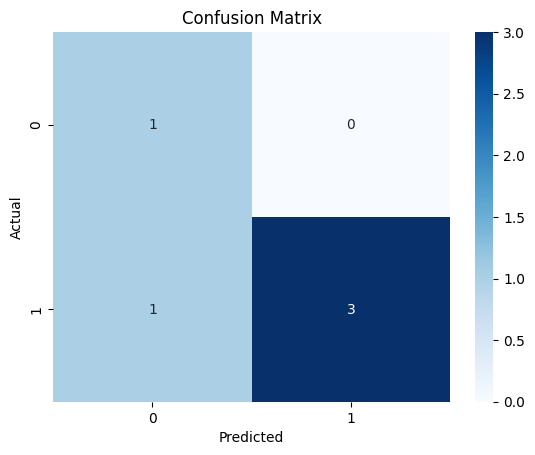

In [18]:
# 📊 Visualization 1: Confusion Matrix Heatmap (on last predictions)
from sklearn.metrics import confusion_matrix

if 'y_test' in locals() and 'y_pred' in locals():
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Variables y_test and y_pred not defined.")


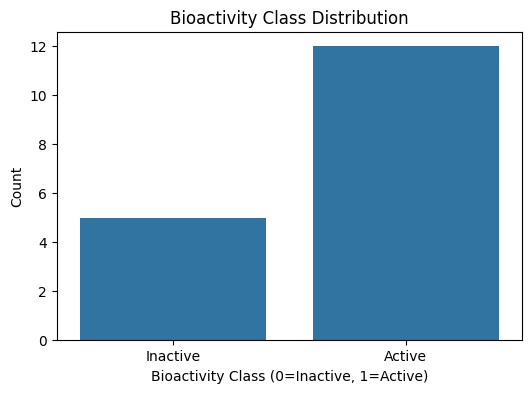

In [19]:
#Visualization 2: Bioactivity Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot of active vs inactive molecules
plt.figure(figsize=(6, 4))
sns.countplot(x='bioactivity_class', data=data)
plt.title("Bioactivity Class Distribution")
plt.xlabel("Bioactivity Class (0=Inactive, 1=Active)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Inactive', 'Active'])
plt.show()


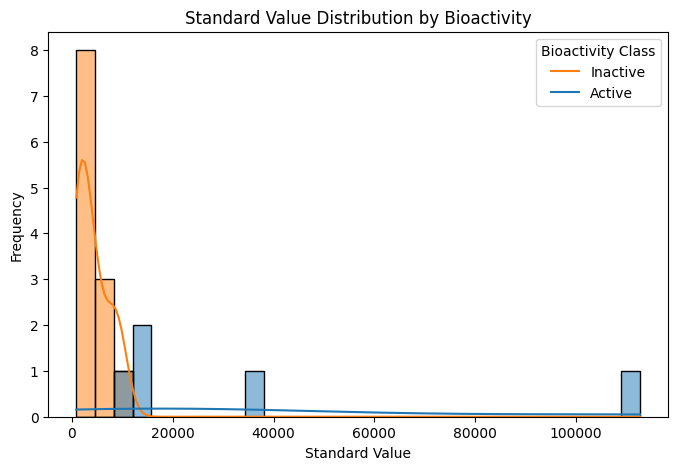

In [20]:
# Visualization 3: Standard Value Distribution by Bioactivity Class
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='standard_value', hue='bioactivity_class', bins=30, kde=True)
plt.title("Standard Value Distribution by Bioactivity")
plt.xlabel("Standard Value")
plt.ylabel("Frequency")
plt.legend(title='Bioactivity Class', labels=['Inactive', 'Active'])
plt.show()


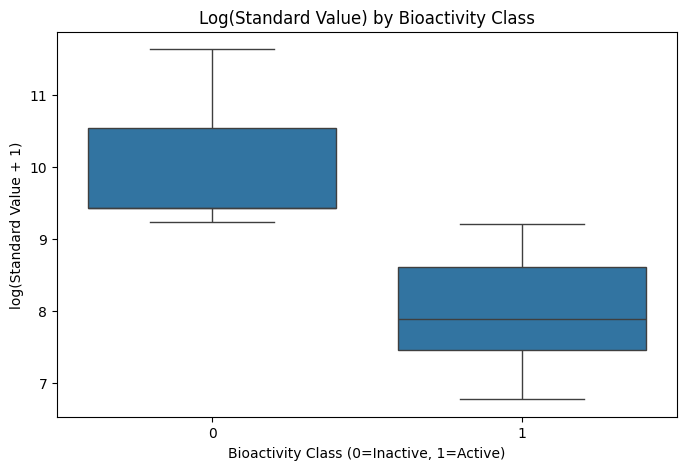

In [21]:
# Visulization 4: Log-Transformed Standard Value vs Bioactivity
import numpy as np

data['log_standard_value'] = np.log1p(data['standard_value'])

plt.figure(figsize=(8, 5))
sns.boxplot(x='bioactivity_class', y='log_standard_value', data=data)
plt.title("Log(Standard Value) by Bioactivity Class")
plt.xlabel("Bioactivity Class (0=Inactive, 1=Active)")
plt.ylabel("log(Standard Value + 1)")
plt.show()


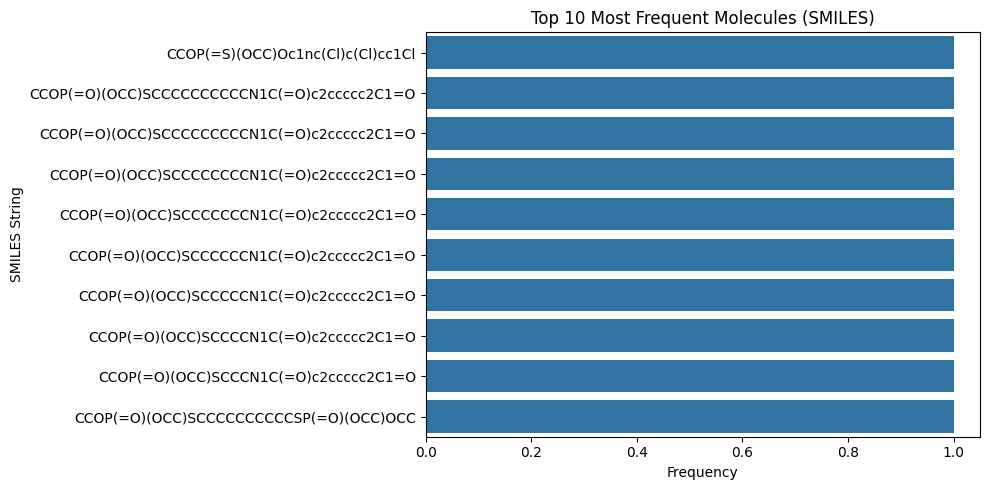

In [22]:
#Visualization 5: Top 10 Most Frequent SMILES Strings

top_smiles = data['canonical_smiles'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_smiles.values, y=top_smiles.index)
plt.title("Top 10 Most Frequent Molecules (SMILES)")
plt.xlabel("Frequency")
plt.ylabel("SMILES String")
plt.tight_layout()
plt.show()


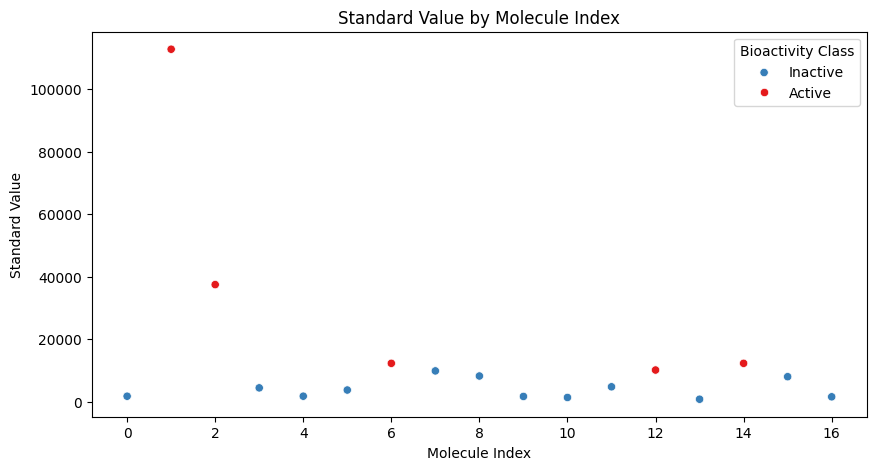

In [23]:
# Visualization 6 : Scatter Plot of Standard Value vs Molecule Index (Colored by Activity)
plt.figure(figsize=(10, 5))
sns.scatterplot(x=range(len(data)), y='standard_value', hue='bioactivity_class', palette='Set1', data=data)
plt.title("Standard Value by Molecule Index")
plt.xlabel("Molecule Index")
plt.ylabel("Standard Value")
plt.legend(title='Bioactivity Class', labels=['Inactive', 'Active'])
plt.show()
